In [1]:
from NN import *

Import Dataset

In [2]:
from torchvision import datasets, transforms 

train_validation_dataset = datasets.EMNIST(root='./data', 
                                           split='letters',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True,
                                        )


independent_test_dataset = datasets.EMNIST(
                             root='./data',
                             split='letters',
                             train=False,
                             transform=transforms.ToTensor(),
                             )


In [16]:
type(train_validation_dataset)
n_classes = len(train_validation_dataset.classes)-1
n_datapoints = len(train_validation_dataset.targets)

X_train = np.array(train_validation_dataset.data.reshape(-1,28*28))
y_train = np.array([[1 if temp == i+1 else 0 for i in range(n_classes)] for temp in train_validation_dataset.targets])

In [17]:
X_test = np.array(independent_test_dataset.data.reshape(-1,28*28))
y_test = np.array([[1 if temp == i+1 else 0 for i in range(n_classes)] for temp in independent_test_dataset.targets])

In [18]:
#standard scaler 
X_mean = np.mean(X_train,axis=0, keepdims=True)
X_std = np.std(X_train,axis=0,keepdims=True)
eps = 1e-8
X_train = (X_train-X_mean)/(X_std + eps)
X_test = (X_test-X_mean)/(X_std + eps)

In [6]:
X_train.min()

0

In [12]:
X_train = X_train/256.0
X_test = X_test /256

In [19]:
model = NN(Linear(28*28,1024), ReLU(), Dropout(0.3), Linear(1024,n_classes), Softmax())

epoch=0, train_loss[epoch]=0.03974851066196984, val_loss[epoch]=0.28401980734096394, train_acc[epoch]=85.58352187028657, val_acc[epoch]=84.04380341880342
epoch=1, train_loss[epoch]=0.020879955568006495, val_loss[epoch]=0.23716371885737605, train_acc[epoch]=89.21191553544496, val_acc[epoch]=86.85897435897436
epoch=2, train_loss[epoch]=0.01738627856128336, val_loss[epoch]=0.21658873700257553, train_acc[epoch]=90.51564856711916, val_acc[epoch]=87.54273504273505
epoch=3, train_loss[epoch]=0.015686351151420034, val_loss[epoch]=0.2022853262844651, train_acc[epoch]=91.44042232277526, val_acc[epoch]=88.23717948717949
epoch=4, train_loss[epoch]=0.014643032232989767, val_loss[epoch]=0.20489754239967609, train_acc[epoch]=91.44419306184012, val_acc[epoch]=87.57478632478633
epoch=5, train_loss[epoch]=0.013638821381186265, val_loss[epoch]=0.18664593553561198, train_acc[epoch]=92.73755656108598, val_acc[epoch]=88.55235042735042
epoch=6, train_loss[epoch]=0.012616719468923475, val_loss[epoch]=0.180349

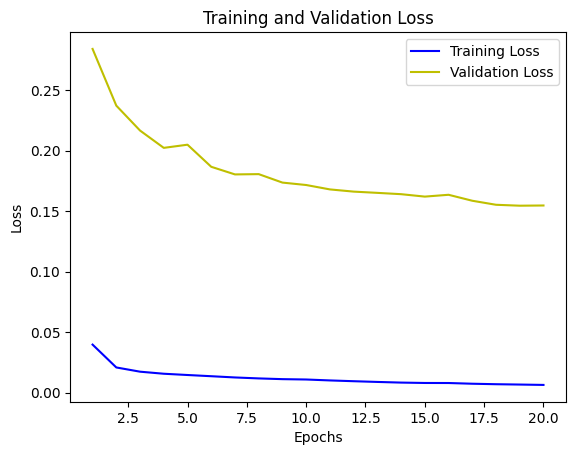

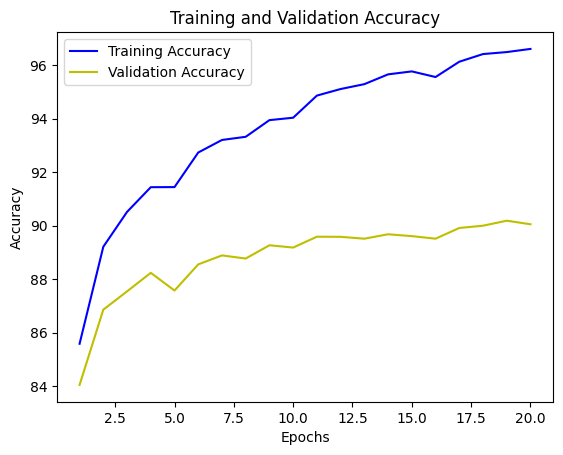

In [20]:
model.train(cross_entropy, cross_entropy_grad, X_train, y_train, batch_size=2048, epochs=20, learning_rate=5e-3)

In [24]:
model.save("model1024_3.pkl")

In [22]:
model.eval(X_test,y_test,batch_size=2048)

0.8973557692307692

In [21]:
id = np.random.randint(0,len(X_train))
x_ = X_train[id:id+1].T 
y_ = y_train[id:id+1].T 

print(model(x_))


[[4.45116634e-06]
 [4.53162807e-06]
 [3.53553076e-07]
 [8.59187604e-07]
 [9.99004249e-01]
 [1.99136923e-08]
 [6.43115465e-09]
 [1.03401883e-07]
 [8.26942614e-11]
 [1.06527418e-10]
 [2.68772884e-05]
 [1.48437765e-11]
 [2.87164102e-10]
 [1.36284963e-07]
 [8.14943406e-09]
 [4.77140150e-07]
 [7.34469979e-11]
 [5.03884495e-05]
 [3.31194223e-11]
 [8.66284492e-04]
 [1.05180796e-07]
 [1.33072448e-08]
 [1.52332377e-10]
 [4.13690038e-07]
 [2.91189439e-09]
 [4.07180334e-05]]


In [22]:
print(y_)

[[0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [23]:
np.argmax(model(x_),axis=0) == np.argmax(y_,axis=0)

array([ True])